In [2]:
from chebai.result.base import ResultFactory, ResultProcessor
from chebai.preprocessing.datasets.chebi import ChEBIOver100
from chebai.preprocessing.datasets.base import XYBaseDataModule
from chebai.models.electra import Electra
from chebai.models.base import ChebaiBaseNet
import torch
import os
import pandas as pd
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score, MultilabelF1Score
import numpy as np
from functools import partial

In [2]:
class CustomResultsProcessor(ResultProcessor):

    @classmethod
    def _identifier(cls) -> str:
        return 'custom_results_processor'

    def process_prediction(self, proc_id, features, labels, pred, ident):
        print(f'id: {proc_id}')
        print(f'features: {features}')
        print(f'labels: {labels}')
        print(f'pred: {pred}')

In [3]:
model_path_v148 = os.path.join('logs', 'chebi100_bce_unweighted', 'version_6', 'checkpoints',
                          'per_epoch=99_val_loss=0.0252_val_micro-f1=0.89.ckpt')
model_path_v200 = 'electra_c100_bce_unweighted.ckpt'
model_v148 = Electra.load_from_checkpoint(model_path_v148).to('cpu')
model_v200 = Electra.load_from_checkpoint(model_path_v200).to('cpu')
data_module_v200 = ChEBIOver100()
data_module_v148 = ChEBIOver100(chebi_version_train=148)
#dataset = torch.load(data_path)
#processors = [CustomResultsProcessor()]
#factory = ResultFactory(model, data_module, processors)
#factory.execute(data_path)

In [4]:
# construct mapping (not used)
filename_200 = 'classes.txt'
filename_148 = f'classes_v148.txt'
with open(os.path.join(data_module_v200.raw_dir, filename_200), "r") as file:
    v200_classes = file.readlines()
with open(os.path.join(data_module_v200.raw_dir, filename_148), "r") as file:
    v148_classes = file.readlines()
# find index in orig_classes for every class in new_classes
mapping = []
for ind, v200_class in enumerate(v200_classes):
    if v200_class in v148_classes:
        mapping.append(v148_classes.index(v200_class))
    else:
        mapping.append(None)

In [16]:
# get list of classes that appear in v200 and v148
common_classes = []
for v200_class in v200_classes:
    if v200_class in v148_classes:
        common_classes.append(v200_class)
# get filter if a class in v200/v148 is a common class
common_classes_mask_v200 = torch.tensor([[c in common_classes for c in v200_classes]])
common_classes_mask_v148 = torch.tensor([[c in common_classes for c in v148_classes]])

In [ ]:
print(len(common_classes))

In [5]:
# (not used)
#mapping = [-1 if new_class not in orig_classes else orig_classes.index(new_class) for new_class in
#                   new_classes]
#input = torch.tensor(np.random.random([1, 854]))
def _apply_mapping(input, index):
    orig_ind = mapping[index]
    if orig_ind is not None:
        return input[0, orig_ind].item()
    return None
# mapping between model outputs / labels for chebi v200 (with 854 classes) and chebi v148 (with 709 classes)
def apply_mapping(mapping: [], input: torch.Tensor):
        input = input.detach().numpy()
        output = np.array(np.zeros((1, len(mapping))))
        for ind, value in enumerate(input[0]):
            if mapping[ind] is not None:
                output[0, mapping[ind]] = value
        return torch.tensor(output)


In [58]:
input = torch.Tensor([[3.4, 5.8, 6.2, 111, 405]])
print(input[0])
for ind, value in enumerate(input[0]):
    print(ind)
    print(mapping[ind])
print(apply_mapping(mapping, input))

tensor([  3.4000,   5.8000,   6.2000, 111.0000, 405.0000])
0
None
1
None
2
0
3
None
4
1
tensor([[  6.2000, 405.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.

In [39]:
# get predictions from model
def evaluate_model(model: ChebaiBaseNet, data_module: XYBaseDataModule, common_classes_mask = None):
    collate = data_module.reader.COLLATER()
    data_path = os.path.join(data_module.processed_dir, data_module.processed_file_names_dict['test'])
    data_list = torch.load(data_path)
    preds_list = []
    labels_list = []

    for row in tqdm.tqdm(data_list):
        processable_data = model._process_batch(collate([row]), 0)
        model_output = model(processable_data)
        preds, labels = model._get_prediction_and_labels(processable_data, processable_data["labels"], model_output)
        if common_classes_mask is not None:
            preds = preds[common_classes_mask]
            labels = labels[common_classes_mask]
            preds_list.append(preds.unsqueeze(0))
            labels_list.append(labels.unsqueeze(0))
        else:
            preds_list.append(preds)
            labels_list.append(labels)

    test_preds = torch.cat(preds_list)
    test_labels = torch.cat(labels_list)
    print(test_preds.shape)
    print(test_labels.shape)
    f1_macro = MultilabelF1Score(test_preds.shape[1], average='macro')
    f1_micro = MultilabelF1Score(test_preds.shape[1], average='micro')
    print(f'Macro-F1 on test set with {test_preds.shape[1]} classes: {f1_macro(test_preds, test_labels):3f}')
    print(f'Micro-F1 on test set with {test_preds.shape[1]} classes: {f1_micro(test_preds, test_labels):3f}')

In [21]:
evaluate_model(model_v200, data_module_v200)

Model predicts 854 classes, data contains 854 classes


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [06:25<00:00, 42.82it/s]


Macro-F1 on test set with 854 classes: 0.607030
Micro-F1 on test set with 854 classes: 0.903165


Results:
- model_v200, test set from Martin:
  - Macro-F1 on test set with 854 classes: 0.607030
  - Micro-F1 on test set with 854 classes: 0.903165
- model_v200, test set from me (?) (i dont know where it is from, but it was there and lead to bad results)
- Macro-F1 on test set with 854 classes: 0.003233
- Micro-F1 on test set with 854 classes: 0.155634
- model_v200, test set from Martin (only using classes also present in chebi_v148):
  - Macro-F1 on test set with 701 classes: 0.623063
  - Micro-F1 on test set with 701 classes: 0.905059
- model_v148, test set from ?
  - Macro-F1 on test set: 0.510064
  - Micro-F1 on test set: 0.854736
- model_v148, test set from Martin (modified for training with 709 classes)
  - Macro-F1 on test set with 709 classes: 0.513283
  - Micro-F1 on test set with 709 classes: 0.854591
- model_v148, test set from Martin (modified for training with 709 classes, only using classes also present in chebi_v200)
  - Macro-F1 on test set with 701 classes: 0.519968
  - Micro-F1 on test set with 701 classes: 0.855442

In [40]:
evaluate_model(model_v200, data_module_v200, common_classes_mask_v200)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [07:21<00:00, 37.36it/s]


torch.Size([16486, 701])
torch.Size([16486, 701])
Macro-F1 on test set with 701 classes: 0.623063
Micro-F1 on test set with 701 classes: 0.905059


In [41]:
evaluate_model(model_v148, data_module_v148)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [05:31<00:00, 49.69it/s]


torch.Size([16486, 709])
torch.Size([16486, 709])
Macro-F1 on test set with 709 classes: 0.513283
Micro-F1 on test set with 709 classes: 0.854591


In [42]:
evaluate_model(model_v148, data_module_v148, common_classes_mask_v148)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16486/16486 [05:16<00:00, 52.07it/s]


torch.Size([16486, 701])
torch.Size([16486, 701])
Macro-F1 on test set with 701 classes: 0.519968
Micro-F1 on test set with 701 classes: 0.855442


In [28]:
print(common_classes_mask_v200.shape)

torch.Size([1, 854])


In [11]:
# visualize results from csv
df = pd.read_csv(os.path.join('server-results', 'version_6', 'metrics.csv'))
df_loss = df.melt(id_vars='epoch', value_vars=['val_loss_epoch', 'train_loss_epoch'])
df_macro = df.melt(id_vars='epoch', value_vars=['train_macro-f1', 'val_macro-f1', ])
df_micro = df.melt(id_vars='epoch', value_vars=['train_micro-f1', 'val_micro-f1', ])
print(df_loss)

       epoch          variable     value
0        0.0    val_loss_epoch       NaN
1        0.0    val_loss_epoch       NaN
2        0.0    val_loss_epoch       NaN
3        0.0    val_loss_epoch       NaN
4        0.0    val_loss_epoch       NaN
...      ...               ...       ...
17227    NaN  train_loss_epoch       NaN
17228    NaN  train_loss_epoch       NaN
17229    NaN  train_loss_epoch       NaN
17230   99.0  train_loss_epoch       NaN
17231   99.0  train_loss_epoch  0.013129

[17232 rows x 3 columns]


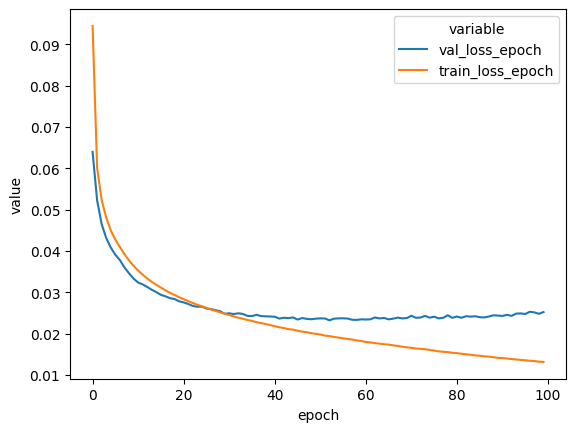

In [12]:
lineplt = sns.lineplot(df_loss, x='epoch', y='value', hue='variable')
plt.show()

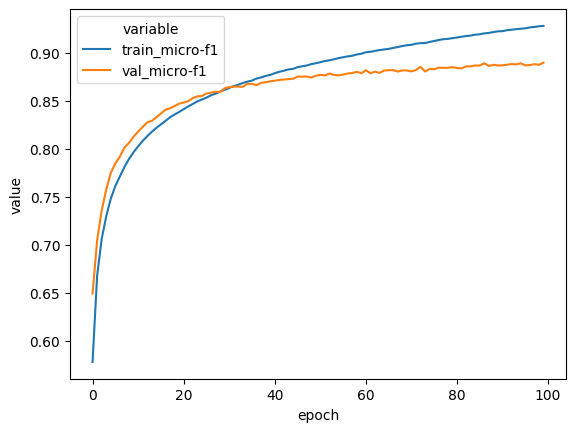

In [13]:
sns.lineplot(df_micro, x='epoch', y='value', hue='variable')
plt.show()

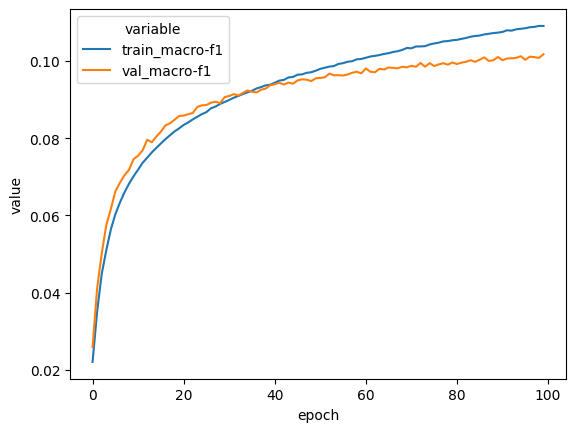

In [14]:
# values are not correct
sns.lineplot(df_macro, x='epoch', y='value', hue='variable')
plt.show()